# Histopathological Lung Cancer Image Classification
### Alice Pascalev & Will Arliss

---
---
---
# Introduction

[**Presentation recording link**](https://www.youtube.com/watch?v=bo4E9ujj9Ow)

The dataset utilized in this project is [Lung and Colon Cancer Histopathological Image Dataset (LC25000)](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images), a dataset of 25,000 color images of lung and colon tissue compiled and prepared by Borkowski et al., which we accessed via Kaggle. The 25,000 images are in 5 classes, each containing 5,000 images. The classes are as follows:

Benign Colonic tissue
Colon adenocarcinoma (cancerous)
Benign Lung tissue
Lung adenocarcinoma (cancerous)
Lung Squamous cell carcinoma (cancerous)

The images were generated from an original set of 750 images of lung tissue and 500 images of colon tissue (250 images per class), and augmented to a set of 25,000 (5,000 per class) for public use. All of the data is de-identified, HIPAA compliant, and from verified sources.

For the purpose of this project, we are focusing on the three lung classes - benign lung tissue, lung adenocarcinoma, and lung squamous cell carcinoma.

The motivation behind choosing the dataset on lung cancer stems from a combination of our interests in convolutional neural networks (CNNs) and healthcare applications of data science. CNNs have demonstrated remarkable performance in image recognition tasks, making them well-suited for analyzing medical images. Additionally, lung cancer holds a significant place in healthcare due to its high mortality rate, which ranges from 3% to 65% over 5 years depending on the stage and type. As one of the leading causes of cancer-related deaths, it presents a pressing challenge for the medical community. By leveraging the power of CNNs, we aim to build a model which can distinguish cancerous tissue from healthy tissue, and distinguish between the two types of lung cancer. With aggressive cancers such as lung, colon, and pancreatic cancer, early detection and diagnosis is key to survival. With the advancements in medical imaging and machine learning, early detection with CNNs can save many lives.

Adenocarcinoma is the most common type of lung cancer, accounting for 40% of cases, with incidences rising over the past few decades. It has 10 subtypes. Squamous cell carcinoma accounts for 20% of lung cancers.

The lung tissue dataset consists of 15,000 768 x 768 pixel images distributed equally across three classes. This posed a challenge in Colab, where we were working with limited memory, which resulted in extremely long runtime (and often also causing Colab to crash). To mitigate this, we made the decision to both resize the images to 256x256 (224x224 for pretrained models), and undersample the dataset to 1,200 (1,000 for training, 100 for validation, 100 for testing) to train the model. Because the dataset was previously augmented from 250 images from each class to 5,000 of each class, there are still more images in our dataset than there were originally.


---
---
---
# Experiments

In [ ]:
%matplotlib inline

In [ ]:
!pip3 install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.7 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import load_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT = 'drive/MyDrive/Colab Notebooks/dats6202/dats6202-final-project'
SEED = 1

In [ ]:
def calculate_mean_image(base_dir, class_folders, num_samples=100):
    """Calculate mean image for all images in a folder
    """

    mean_images = []

    for class_folder in class_folders:
        class_path = os.path.join(base_dir, class_folder)
        class_images = os.listdir(class_path)[:num_samples]

        class_mean_image = None
        total_images = 0

        for image_name in class_images:
            image_path = os.path.join(class_path, image_name)
            image = plt.imread(image_path)

            if class_mean_image is None:
                class_mean_image = image.astype(np.float64)
            else:
                class_mean_image += image.astype(np.float64)

            total_images += 1

        class_mean_image /= total_images
        mean_images.append(class_mean_image.astype(np.uint8))

    return mean_images


def baseline():
    """Return baseline model
    """

    return keras.models.Sequential([
        keras.models.Sequential([
            keras.layers.Rescaling(1/255.),
            keras.layers.Resizing(256, 256),
            keras.layers.Conv2D(32, 5, activation='relu', padding='same', input_shape=[256, 256, 3]),
            keras.layers.MaxPooling2D(2),
        ]),
        keras.models.Sequential([
            keras.layers.Conv2D(64, 2, activation='relu', padding='same'),
            keras.layers.Conv2D(64, 2, activation='relu', padding='same'),
            keras.layers.MaxPooling2D(2),
        ]),
        keras.models.Sequential([
            keras.layers.Conv2D(128, 2, activation='relu', padding='same'),
            keras.layers.Conv2D(128, 2, activation='relu', padding='same'),
            keras.layers.MaxPooling2D(2),
        ]),
        keras.models.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dropout(0.5),
        ]),
        keras.layers.Dense(3, activation='softmax')
    ])


def mobilenet_v2():
    """MobileNetV2 model for fine-tuning.
    """

    input_layer = keras.layers.Input([None, None, 3], dtype=tf.float32)
    pretrained_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet')
    average_pooling = keras.layers.GlobalAveragePooling2D()
    output_layer = keras.layers.Dense(3, activation='softmax')

    # `mobilenet_v2.preprocess_input` scales inputs between 0 and 1
    X = keras.applications.mobilenet_v2.preprocess_input(input_layer)
    X = pretrained_model(X)
    X = average_pooling(X)
    X = output_layer(X)

    model = keras.Model(inputs=input_layer, outputs=X)

    return model, pretrained_model


def mobilenet_v3_small():
    """MobileNetV3-Small model for fine-tuning.
    """

    input_layer = keras.layers.Input([None, None, 3], dtype=tf.float32)
    pretrained_model = keras.applications.MobileNetV3Small(include_top=False, weights='imagenet')
    average_pooling = keras.layers.GlobalAveragePooling2D()
    output_layer = keras.layers.Dense(3, activation='softmax')

    # `mobilenet_v3.preprocess_input` scales inputs between -1 and 1
    X = keras.applications.mobilenet_v3.preprocess_input(input_layer)
    X = pretrained_model(X)
    X = average_pooling(X)
    X = output_layer(X)

    model = keras.Model(inputs=input_layer, outputs=X)

    return model, pretrained_model


def nasnet_mobile():
    """NasNetMobile model for fine-tuning.
    """

    input_layer = keras.layers.Input([None, None, 3], dtype=tf.float32)
    pretrained_model = keras.applications.NASNetMobile(
        include_top=False, weights='imagenet', input_shape=(224,224,3))
    average_pooling = keras.layers.GlobalAveragePooling2D()
    output_layer = keras.layers.Dense(3, activation='softmax')

    X = keras.preprocessing.image.smart_resize(input_layer, (224, 224))
    # `nasnet.preprocess_input` scales inputs between -1 and 1
    X = keras.applications.nasnet.preprocess_input(X)
    X = pretrained_model(X)
    X = average_pooling(X)
    X = output_layer(X)

    model = keras.Model(inputs=input_layer, outputs=X)

    return model, pretrained_model


def get_data(path: str, valid_size: int, test_size: int,
             undersample: int = None, replace: bool = False, seed: int = None):
    """Load train/val/test data
    """

    train = load_dataset('imagefolder', data_dir=path, split='train')

    if undersample is not None:
        print('undersampling', undersample)
        index = np.random.default_rng(seed).choice(len(train), size=undersample, replace=replace)
        train = train.select(index)

    n = len(train)
    split = train.train_test_split(shuffle=True, train_size=n-test_size, seed=seed)
    train, test = split['train'], split['test']
    split = train.train_test_split(shuffle=True, train_size=n-test_size-valid_size, seed=seed)
    train, valid = split['train'], split['test']

    names = train.info.features['label'].names
    values = train.info.features['label'].str2int(names)
    mapping = dict(zip(names, values))

    print('train', len(train), len(set(train['label'])))
    print('valid', len(valid), len(set(valid['label'])))
    print('test', len(test), len(set(test['label'])))

    return (train, valid, test), mapping


def cast_float(image, label):
    """Cast images as tf.float32 type
    """

    return tf.cast(image, tf.float32), label


---
### Load Data

In [ ]:
# Set path to data directory
dta_path = os.path.dirname(ROOT + '/lung_colon_image_set/lung_image_sets/')

# Load dataset
dataset = load_dataset('imagefolder', data_dir=dta_path)
del dataset

Resolving data files:   0%|          | 0/15000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-d04b0c5f064e8150/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Call the data loading function to get train/val/test data and the label map
(data_train, data_val, data_test), mapping = get_data(
    path=dta_path,
    valid_size=100,
    test_size=100,
    undersample=1_200, # Undersample for space/time constraints
    replace=False,
    seed=SEED,
)

Resolving data files:   0%|          | 0/15000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-d04b0c5f064e8150/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
undersampling 1200
train 1000 3
valid 100 3
test 100 3


In [ ]:
# Preprocess the data
batch_size = 32
data_train = (data_train
    .to_tf_dataset(columns='image', label_cols='label', batch_size=batch_size)
    .map(cast_float)
    .prefetch(1)
)
data_val = (data_val
    .to_tf_dataset(columns='image', label_cols='label', batch_size=batch_size)
    .map(cast_float)
    .prefetch(1)
)
data_test = (data_test
    .to_tf_dataset(columns='image', label_cols='label', batch_size=batch_size)
    .map(cast_float)
    .prefetch(1)
)

---
### EDA

First, lets take a look at some sample images from each class, so we know what we are working with:


*   Healthy lung tissue - lung_n
*   Lung adenocarcinoma - lung_aca
*   Lung squamous cell carcinoma - lung_scc




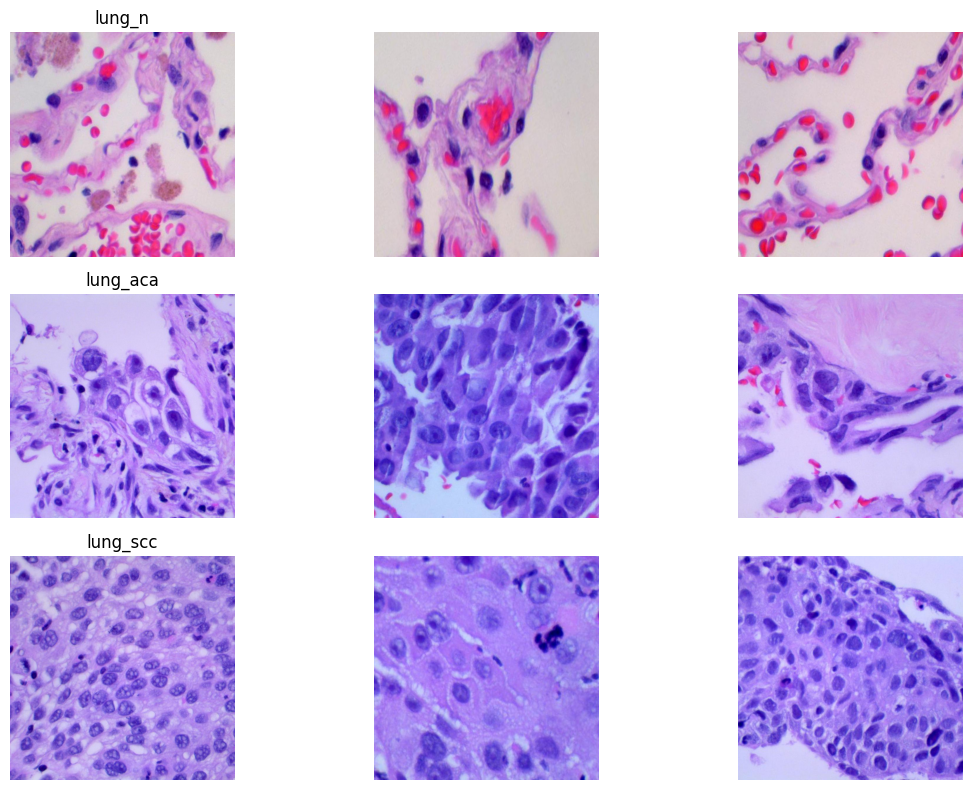

In [ ]:
# List the class folders within the dataset directory
class_folders = ['lung_n', 'lung_aca', 'lung_scc']

# Display a few sample images from each class
num_samples_per_class = 3

fig, axes = plt.subplots(len(class_folders), num_samples_per_class, figsize=(12, 8))

for i, class_folder in enumerate(class_folders):
    class_folder_path = os.path.join(dta_path, class_folder)
    image_files = os.listdir(class_folder_path)[:num_samples_per_class]

    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_folder_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axes[i][j].imshow(image)
        axes[i][j].axis('off')

        if j == 0:
            axes[i][j].set_title(class_folder)

plt.tight_layout()
plt.show()


When grading lung tissue, pathologists stain the tissue with hematoxylin and eosin, which results in the pink & purple colors we see above. This makes the cells and their components visible to the pathologist, who can analyze the size and structure of the cells.

Here we can see a stark difference between healthy tissue and the tissue samples with cancer. Healthy tissue appears light & pink, as healthy tissue should. However, in both cancer classes, the image is darker purple, which is a result of the purple stain on the enlarged & clustered nuclei typical of cancer cells.

Next, lets take a look at the mean image for each class:

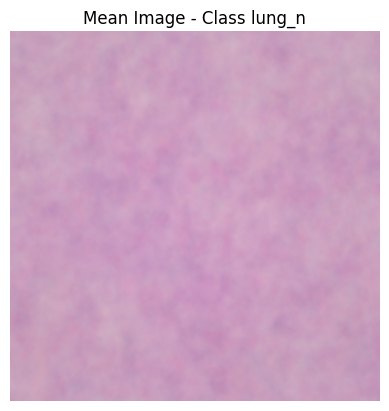

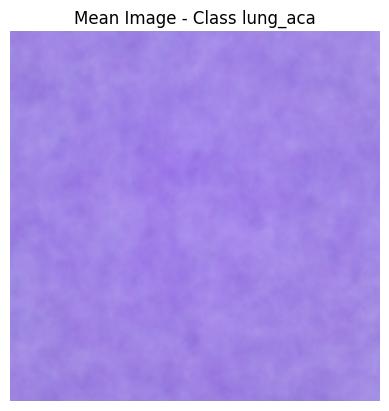

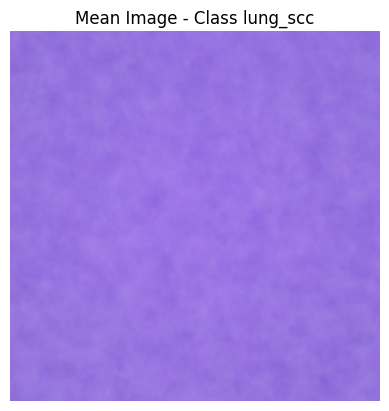

In [ ]:
# Calculate mean image for each class using a subset of 100 images each
class_folders = ['lung_n', 'lung_aca', 'lung_scc']
mean_images = calculate_mean_image(dta_path, class_folders, num_samples=100)

# Visualize mean images for each class
for i, class_folder in enumerate(class_folders):
    plt.imshow(mean_images[i])
    plt.axis('off')
    plt.title(f'Mean Image - Class {class_folder}')
    plt.show()


Based on our sample images we pulled earlier, the mean image of each class is not too surprising. We once again see this stark difference between the healthy class and the two cancer classes. We see a light purple-pink color for the healthy class, and two darker shades of purple for the two cancer classes.
The primary differences between adenocarcinoma and squamous cell carcinoma are thei types of cells they originate from, outer areas of the lung that secrete mucuous (aca), and squamous cells in the central area of the lung (scc), which contributes the differences in the shape and size of the cells.

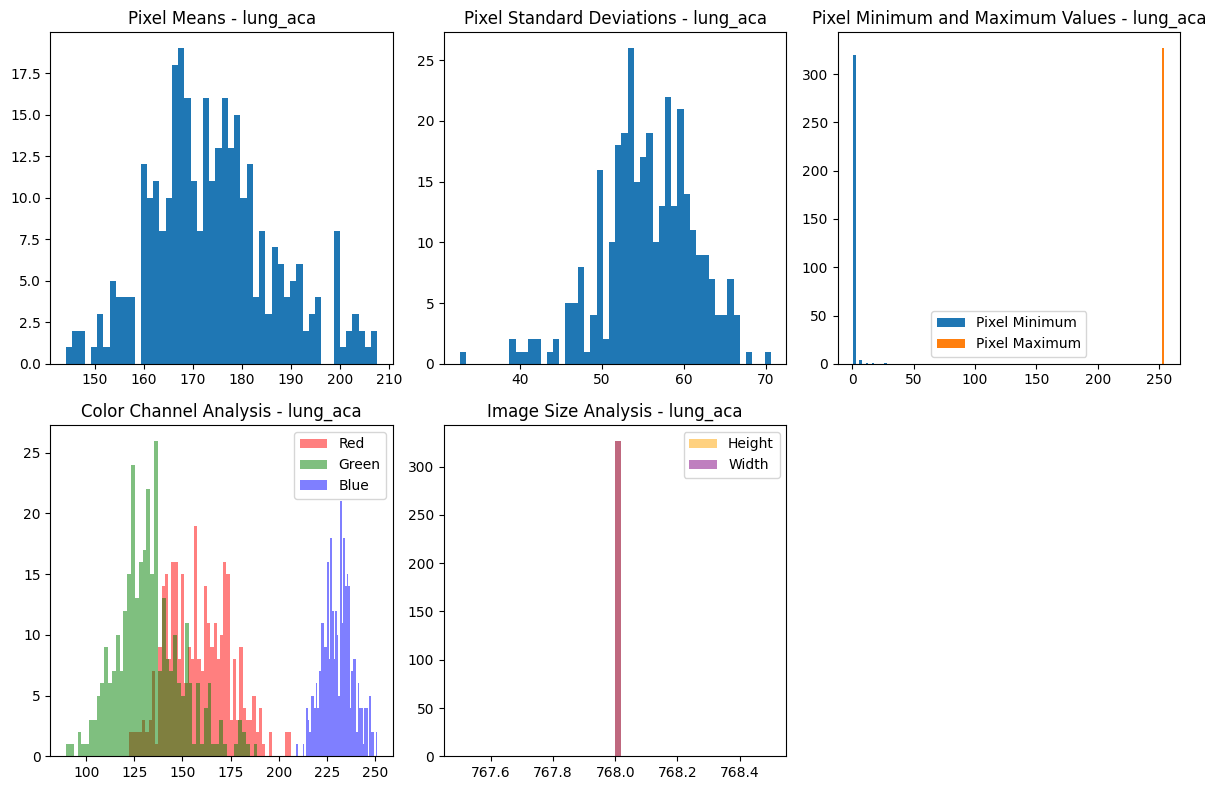

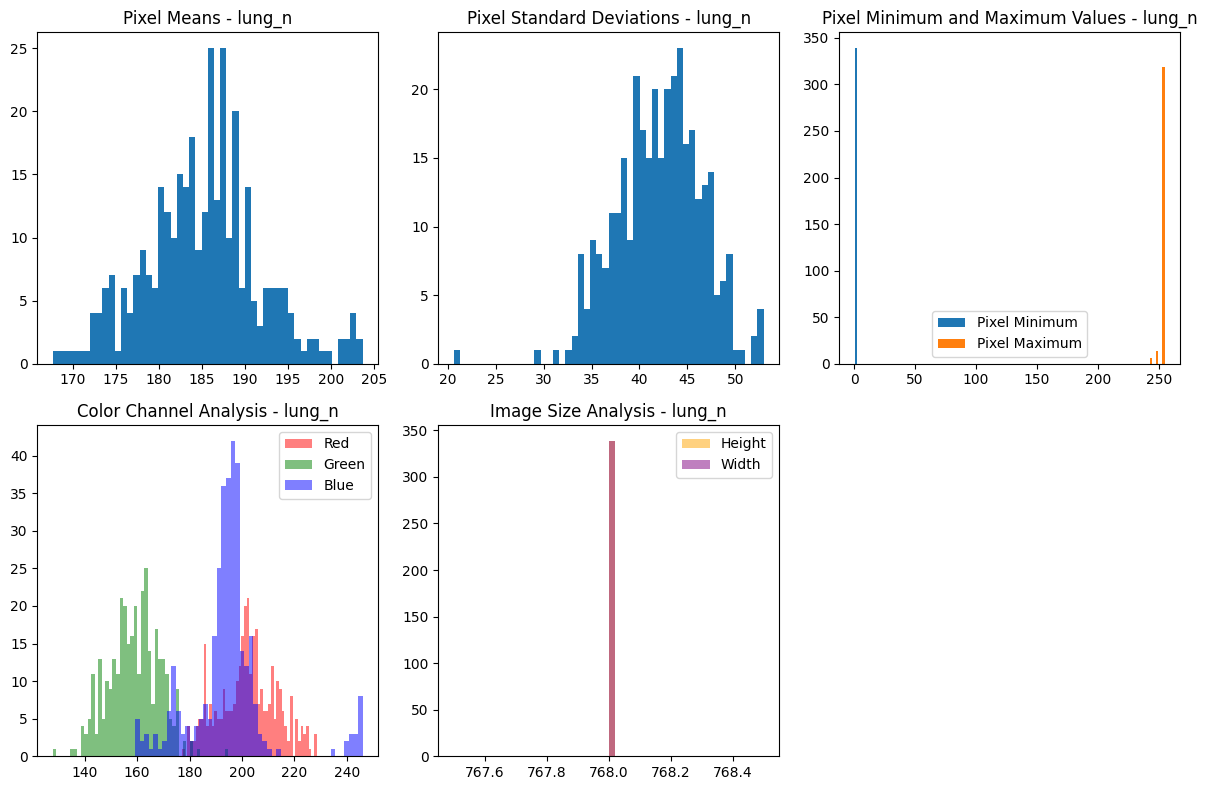

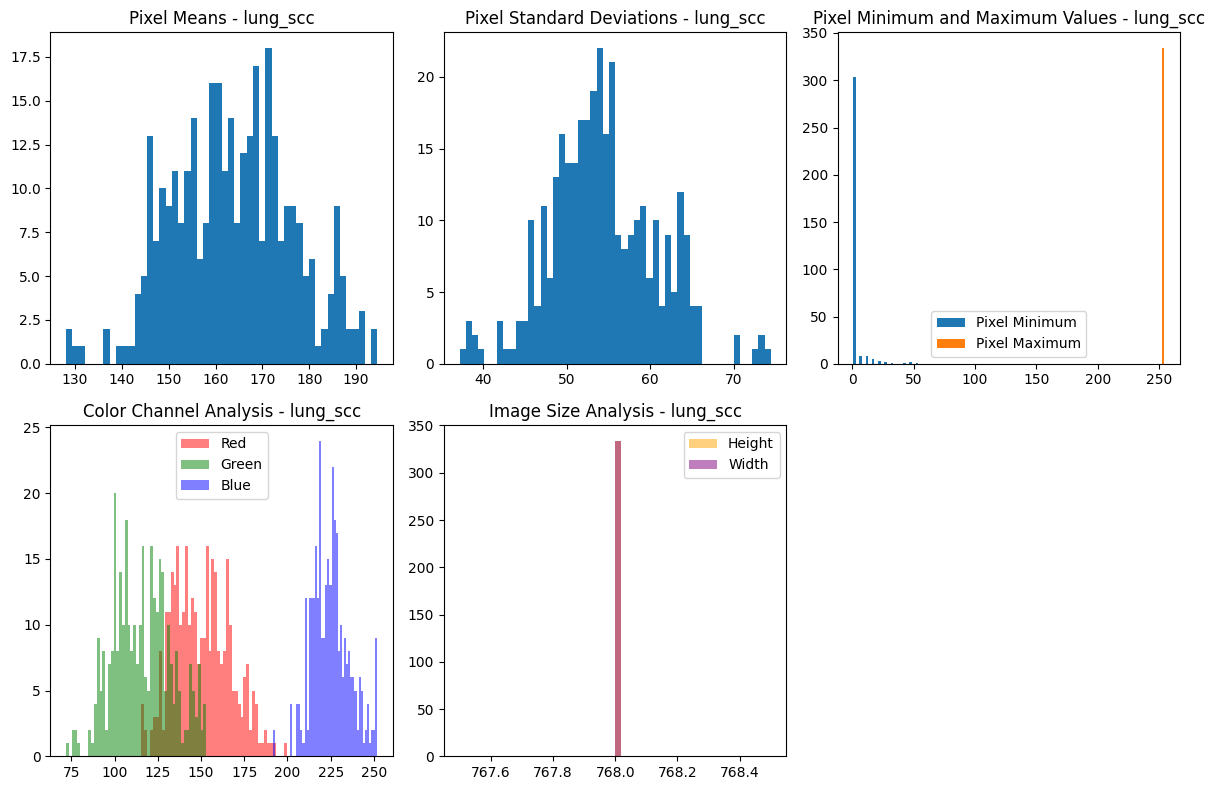

In [ ]:
# Calculate image statistics
pixel_means = []
pixel_stds = []
pixel_min_max = []

# Calculate color channel analysis
red_values = []
green_values = []
blue_values = []

# Calculate image size analysis
heights = []
widths = []

# Store the training data labels
train_labels = []

# Calculate pixel statistics, color channel analysis, and image size analysis for data_train
for data in data_train:
    images = data[0]  # Extract images from data
    labels = data[1]  # Extract labels from data
    train_labels.append(labels)

    for image in images:
        # Calculate pixel statistics
        pixel_means.append(np.mean(image))
        pixel_stds.append(np.std(image))
        pixel_min_max.append((np.min(image), np.max(image)))

        # Calculate color channel analysis
        red_values.append(np.mean(image[:, :, 0]))
        green_values.append(np.mean(image[:, :, 1]))
        blue_values.append(np.mean(image[:, :, 2]))

        # Calculate image size analysis
        heights.append(image.shape[0])
        widths.append(image.shape[1])

# Convert lists to numpy arrays
pixel_means = np.array(pixel_means)
pixel_stds = np.array(pixel_stds)
pixel_min_max = np.array(pixel_min_max)
red_values = np.array(red_values)
green_values = np.array(green_values)
blue_values = np.array(blue_values)
heights = np.array(heights)
widths = np.array(widths)
train_labels = np.concatenate([t.numpy() for t in train_labels])

mapping_rev = {v:k for k, v in mapping.items()}
for i in range(len(mapping)):

    # Plotting the histograms and statistics
    plt.figure(figsize=(12, 8))

    # Pixel statistics
    plt.subplot(2, 3, 1)
    plt.hist(pixel_means[train_labels==i], bins=50)
    plt.title(f'Pixel Means - {mapping_rev[i]}')

    plt.subplot(2, 3, 2)
    plt.hist(pixel_stds[train_labels==i], bins=50)
    plt.title(f'Pixel Standard Deviations - {mapping_rev[i]}')

    plt.subplot(2, 3, 3)
    plt.hist(pixel_min_max[train_labels==i, :], bins=50, label=['Pixel Minimum', 'Pixel Maximum'])
    plt.legend()
    plt.title(f'Pixel Minimum and Maximum Values - {mapping_rev[i]}')

    # Color channel analysis
    plt.subplot(2, 3, 4)
    plt.hist(red_values[train_labels==i], bins=50, color='red', alpha=0.5, label='Red')
    plt.hist(green_values[train_labels==i], bins=50, color='green', alpha=0.5, label='Green')
    plt.hist(blue_values[train_labels==i], bins=50, color='blue', alpha=0.5, label='Blue')
    plt.legend()
    plt.title(f'Color Channel Analysis - {mapping_rev[i]}')

    # Image size analysis
    plt.subplot(2, 3, 5)
    plt.hist(heights[train_labels==i], bins=50, color='orange', alpha=0.5, label='Height')
    plt.hist(widths[train_labels==i], bins=50, color='purple', alpha=0.5, label='Width')
    plt.legend()
    plt.title(f'Image Size Analysis - {mapping_rev[i]}')

    plt.tight_layout()
    plt.show()


As previously mentioned, we have gone ahead and undersampled the data. Let's take a look at the class distribution in the undersampled dataset:

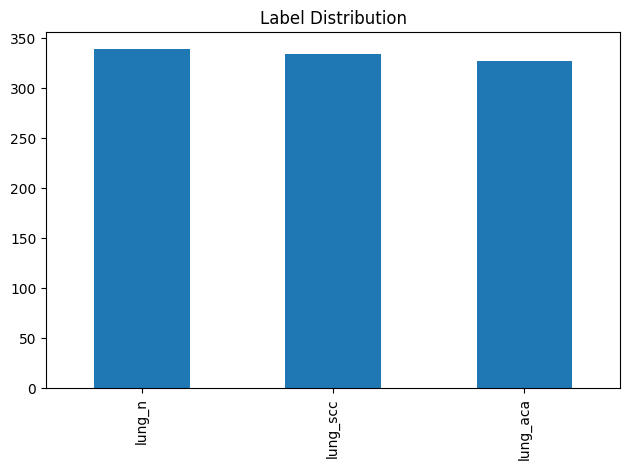

In [ ]:
# Visualize the label distribution
label_dist = pd.Series(train_labels).map(mapping_rev).value_counts()

fig, ax = plt.subplots()
label_dist.plot.bar(ax=ax)
ax.set_title('Label Distribution')
plt.tight_layout()
plt.show()

Here we see that the class distribution remains nearly even after undersampling the data. With an even class distribution, we do not need to worry about over or underfitting as a result of an unbalanced dataset.

---
### Baseline Model

We will now train the baseline model, consisting of three convolutional blocks followed by an MLP unit.

In [ ]:
# Set path for experiment outputs
experiment_path = os.path.dirname(ROOT + '/result_0/')

In [ ]:
# Create directory for model if not exists
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [ ]:
# Write a note with the model name
with open(experiment_path+'/note.txt', 'w', encoding='utf-8') as outfile:
    print('Baseline', file=outfile)

In [ ]:
# Set random state for weight initialization
tf.random.set_seed(SEED)

# Call the baseline model loader
model = baseline()

# Compile the model
model.compile(
    optimizer=keras.optimizers.SGD(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
# Save model checkpoints
model_checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=experiment_path+'/model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
# Reduce learning rate on loss plateau
lr_reduce = keras.callbacks.ReduceLROnPlateau(factor=0.9, patience=1)
# Allow early stopping if no improvement
early_stopping = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

In [ ]:
# Run training
history = model.fit(
    data_train,
    epochs=15,
    validation_data=data_val,
    callbacks=[model_checkpoints, lr_reduce, early_stopping],
)

Epoch 1/15
32/32 [==============================] - 48s 1s/step - loss: 1.0856 - accuracy: 0.3780 - val_loss: 1.1030 - val_accuracy: 0.2900 - lr: 0.0100
Epoch 2/15
32/32 [==============================] - 45s 1s/step - loss: 1.0186 - accuracy: 0.4700 - val_loss: 1.1457 - val_accuracy: 0.2900 - lr: 0.0100
Epoch 3/15
32/32 [==============================] - 46s 1s/step - loss: 0.9787 - accuracy: 0.4870 - val_loss: 0.7585 - val_accuracy: 0.6500 - lr: 0.0090
Epoch 4/15
32/32 [==============================] - 45s 1s/step - loss: 0.9323 - accuracy: 0.5050 - val_loss: 0.7176 - val_accuracy: 0.6500 - lr: 0.0090
Epoch 5/15
32/32 [==============================] - 46s 1s/step - loss: 1.0686 - accuracy: 0.3890 - val_loss: 1.0945 - val_accuracy: 0.3200 - lr: 0.0090
Epoch 6/15
32/32 [==============================] - 45s 1s/step - loss: 1.0702 - accuracy: 0.3270 - val_loss: 1.0390 - val_accuracy: 0.3200 - lr: 0.0081
Epoch 7/15
32/32 [==============================] - 46s 1s/step - loss: 1.0204 - a

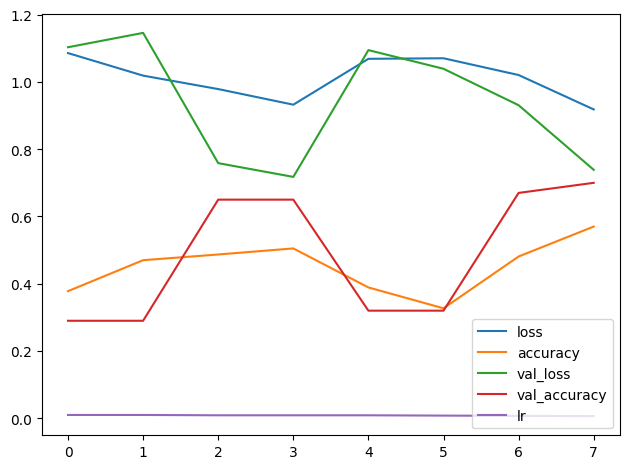

In [ ]:
# Plot the learning curves
history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots()
history_df.plot(ax=ax)
plt.tight_layout()
plt.savefig(experiment_path+'/learning_curve.png')
plt.show()

In [ ]:
# Reload best weights
model.load_weights(filepath=experiment_path+'/model.h5')

In [ ]:
# Check validation accuracy
loss, accuracy = model.evaluate(data_val)
accuracy

4/4 [==============================] - 4s 926ms/step - loss: 0.7387 - accuracy: 0.7000


0.699999988079071

The baseline model achieves 70% accuracy on validation set.

---
### EDA Contd.

We now continue our EDA by extracting intermediate activation maps for further analysis. By passing the inputs through the first few layers of our baseline model, we can see how the images are being embedded in the model's parameter space. We map the embeddings into a 2D plane and plot the outputs.

In [ ]:
# Extract intermediate activation maps for analysis
h = 2
X = keras.models.Sequential(model.layers[:h]).predict(data_train)
y = train_labels
model.layers[:h]

32/32 [==============================] - 41s 1s/step


In [ ]:
# Reduce dimensionality of activation map for plotting
Z = X.reshape(X.shape[0], -1)
Z = PCA(n_components=100).fit_transform(Z)
Z = TSNE(n_components=2).fit_transform(Z)

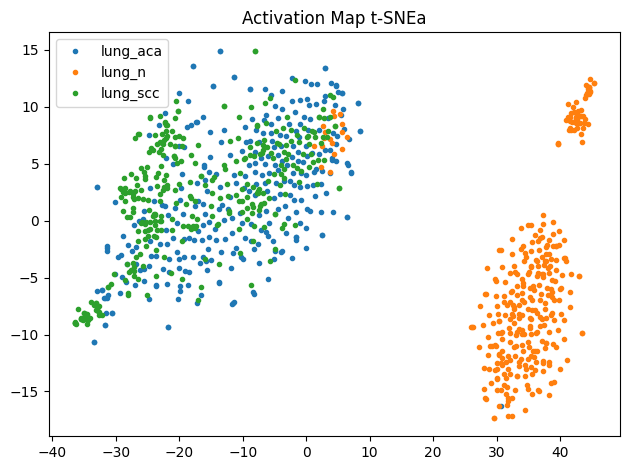

In [ ]:
# Visualize the activation maps for each class
fig, ax = plt.subplots()
for label in range(len(mapping_rev)):
    ax.plot(Z[y==label,0], Z[y==label,1], '.', label=mapping_rev[label])
ax.legend()
ax.set_title('Activation Map t-SNEa')
plt.tight_layout()
plt.savefig(experiment_path+'/activation_map_tsne.png')
plt.show()

---
### Modeling Experiments

While our baseline is a good start, let's experiment with a few different pre-trained models:
*   MobileNetV2
*   MobileNetV3-Small
*   NASNetMobile

The choice to use "mobile" models is motivated by the previously mentioned memory problems. We initially had trouble training larger models like ResNet (the kernel kept crashing or Colab would automatically close before one epoch completes), so we resorted to these smaller models that are designed to operate on limited compute.

---
**MobileNetV2**

MobileNetV2 is mobile CNN that leverages bottleneck and inverted residual blocks for "memory efficient inference" (https://arxiv.org/abs/1801.04381).

In [ ]:
# Set path for experiment outputs
experiment_path = os.path.dirname(ROOT+'/result_1/')

In [ ]:
# Create directory for model if not exists
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [ ]:
# Write a note with the model name
with open(experiment_path+'/note.txt', 'w', encoding='utf-8') as outfile:
    print('MobileNetV2', file=outfile)

In [ ]:
# Set random state for weight initialization
tf.random.set_seed(SEED)

# Call the MobileNetV2 model loader
model, pretrained_model = mobilenet_v2()

# Freeze pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)


In [ ]:
# Save model checkpoints
model_checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=experiment_path+'/model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
# Reduce learning rate on loss plateau
lr_reduce = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
# Allow early stopping if no improvement
early_stopping = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

In [ ]:
# Run first phase of training (just top layers)
history = model.fit(
    data_train,
    epochs=10,
    validation_data=data_val,
    callbacks=[model_checkpoints, lr_reduce, early_stopping],
)

Epoch 1/10
32/32 [==============================] - 50s 1s/step - loss: 0.6294 - accuracy: 0.7670 - val_loss: 0.3894 - val_accuracy: 0.9300 - lr: 0.0100
Epoch 2/10
32/32 [==============================] - 46s 1s/step - loss: 0.3448 - accuracy: 0.9070 - val_loss: 0.2903 - val_accuracy: 0.9500 - lr: 0.0100
Epoch 3/10
32/32 [==============================] - 45s 1s/step - loss: 0.2752 - accuracy: 0.9220 - val_loss: 0.2542 - val_accuracy: 0.9200 - lr: 0.0100
Epoch 4/10
32/32 [==============================] - 46s 1s/step - loss: 0.2395 - accuracy: 0.9300 - val_loss: 0.2355 - val_accuracy: 0.9300 - lr: 0.0100
Epoch 5/10
32/32 [==============================] - 45s 1s/step - loss: 0.2168 - accuracy: 0.9340 - val_loss: 0.2239 - val_accuracy: 0.9300 - lr: 0.0100
Epoch 6/10
32/32 [==============================] - 45s 1s/step - loss: 0.2005 - accuracy: 0.9390 - val_loss: 0.2158 - val_accuracy: 0.9300 - lr: 0.0100
Epoch 7/10
32/32 [==============================] - 46s 1s/step - loss: 0.1881 - a

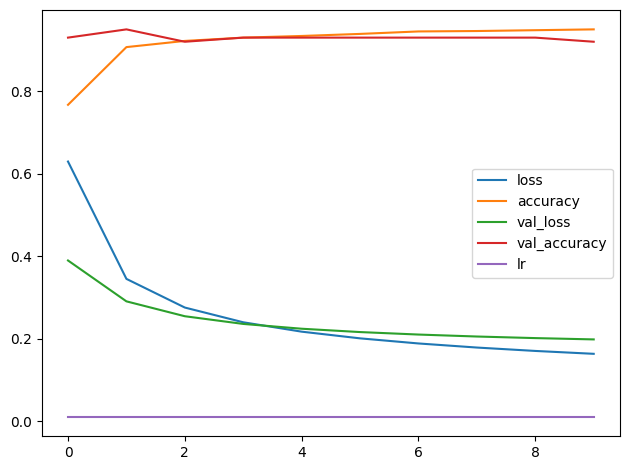

In [ ]:
# Plot the learning curves
history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots()
history_df.plot(ax=ax)
plt.tight_layout()
plt.savefig(experiment_path+'/learning_curve_before_unfreezing.png')
plt.show()

In [ ]:
# Reload best weights from first phase
model.load_weights(filepath=experiment_path+'/model.h5')

# Unfreeze pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = True

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)


In [ ]:
# Run second phase of training (full model)
history = model.fit(
    data_train,
    epochs=5,
    validation_data=data_val,
    callbacks=[model_checkpoints, lr_reduce, early_stopping],
)

Epoch 1/5
32/32 [==============================] - 62s 675ms/step - loss: 0.3341 - accuracy: 0.8570 - val_loss: 1.0154 - val_accuracy: 0.6700 - lr: 1.0000e-04
Epoch 2/5
32/32 [==============================] - 46s 1s/step - loss: 0.0635 - accuracy: 0.9860 - val_loss: 1.2568 - val_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 3/5
32/32 [==============================] - 46s 1s/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 1.1614 - val_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 4/5
32/32 [==============================] - 46s 1s/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.1648 - val_accuracy: 0.6900 - lr: 5.0000e-05
Epoch 5/5
32/32 [==============================] - 46s 1s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.2353 - val_accuracy: 0.6800 - lr: 5.0000e-05


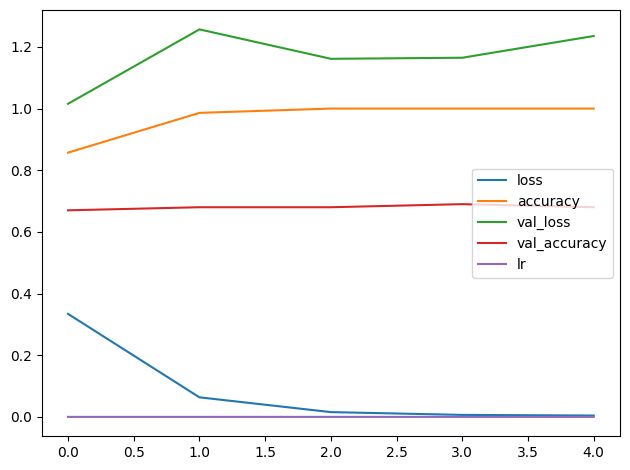

In [ ]:
# Plot the learning curves
history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots()
history_df.plot(ax=ax)
plt.tight_layout()
plt.savefig(experiment_path+'/learning_curve_after_unfreezing.png')
plt.show()

In [ ]:
# Reload the best weights from either first phase or second phase
try:
    model.load_weights(filepath=experiment_path+'/model.h5')
except ValueError:
    # If best model was before unfreezeing, layers must be frozen again
    for layer in pretrained_model.layers:
        layer.trainable = False
    model.load_weights(filepath=experiment_path+'/model.h5')

In [ ]:
# Check validation accuracy
loss, accuracy = model.evaluate(data_val)
accuracy

4/4 [==============================] - 4s 888ms/step - loss: 0.2903 - accuracy: 0.9500


0.949999988079071

MobileNetV2 achieves 95% accuracy on validation set.

---
**MobileNetV3-Small**

MobileNetV3-Small is an extension of MobileNetV2 which uses advanced search algorithms to obtain a network architecture targeted at low-resource use cases (https://arxiv.org/abs/1905.02244). The model also incorporates special non-linearities into the convolutional blocks.

In [ ]:
# Set path for experiment outputs
experiment_path = os.path.dirname(ROOT+'/result_2/')

In [ ]:
# Create directory for model if not exists
if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

In [ ]:
# Write a note with the model name
with open(experiment_path+'/note.txt', 'w', encoding='utf-8') as outfile:
    print('MobileNetV3Small', file=outfile)

In [ ]:
# Set random state for weight initialization
tf.random.set_seed(SEED)

# Call the MobileNetV3Small model loader
model, pretrained_model = mobilenet_v3_small()

# Freeze pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)


In [ ]:
# Save model checkpoints
model_checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=experiment_path+'/model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
# Reduce learning rate on loss plateau
lr_reduce = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
# Allow early stopping if no improvement
early_stopping = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

In [ ]:
# Run first phase of training (just top layers)
history = model.fit(
    data_train,
    epochs=10,
    validation_data=data_val,
    callbacks=[model_checkpoints, lr_reduce, early_stopping],
)

Epoch 1/10
32/32 [==============================] - 51s 1s/step - loss: 0.7290 - accuracy: 0.7290 - val_loss: 0.5318 - val_accuracy: 0.8400 - lr: 0.0100
Epoch 2/10
32/32 [==============================] - 46s 1s/step - loss: 0.4287 - accuracy: 0.8890 - val_loss: 0.4026 - val_accuracy: 0.8500 - lr: 0.0100
Epoch 3/10
32/32 [==============================] - 46s 1s/step - loss: 0.3465 - accuracy: 0.9070 - val_loss: 0.3453 - val_accuracy: 0.8500 - lr: 0.0100
Epoch 4/10
32/32 [==============================] - 46s 1s/step - loss: 0.3039 - accuracy: 0.9140 - val_loss: 0.3123 - val_accuracy: 0.8700 - lr: 0.0100
Epoch 5/10
32/32 [==============================] - 46s 1s/step - loss: 0.2766 - accuracy: 0.9180 - val_loss: 0.2907 - val_accuracy: 0.8800 - lr: 0.0100
Epoch 6/10
32/32 [==============================] - 46s 1s/step - loss: 0.2572 - accuracy: 0.9220 - val_loss: 0.2754 - val_accuracy: 0.8900 - lr: 0.0100
Epoch 7/10
32/32 [==============================] - 46s 1s/step - loss: 0.2422 - a

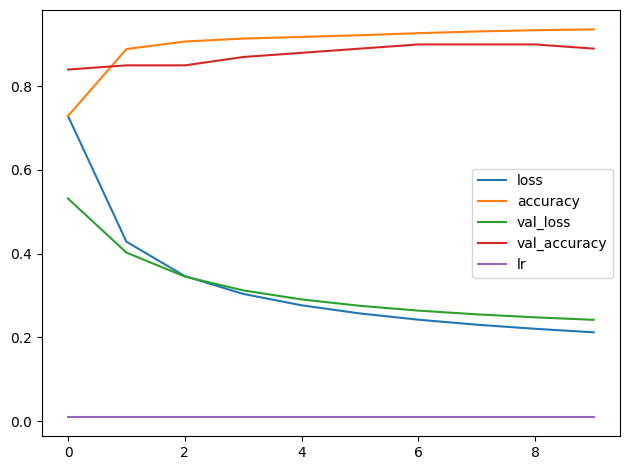

In [ ]:
# Plot the learning curves
history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots()
history_df.plot(ax=ax)
plt.tight_layout()
plt.savefig(experiment_path+'/learning_curve_before_unfreezing.png')
plt.show()

In [ ]:
# Reload best weights from first phase
model.load_weights(filepath=experiment_path+'/model.h5')

# Unfreeze pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = True

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)


In [ ]:
# Run second phase of training (full model)
history = model.fit(
    data_train,
    epochs=5,
    validation_data=data_val,
    callbacks=[model_checkpoints, lr_reduce, early_stopping],
)

Epoch 1/5
32/32 [==============================] - 59s 769ms/step - loss: 0.4316 - accuracy: 0.8470 - val_loss: 0.4300 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 2/5
32/32 [==============================] - 46s 1s/step - loss: 0.1839 - accuracy: 0.9400 - val_loss: 0.7518 - val_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 3/5
32/32 [==============================] - 45s 1s/step - loss: 0.1142 - accuracy: 0.9630 - val_loss: 0.9159 - val_accuracy: 0.7700 - lr: 1.0000e-04
Epoch 4/5
32/32 [==============================] - 46s 1s/step - loss: 0.0779 - accuracy: 0.9780 - val_loss: 0.9162 - val_accuracy: 0.7700 - lr: 5.0000e-05
Epoch 5/5
32/32 [==============================] - 46s 1s/step - loss: 0.0592 - accuracy: 0.9840 - val_loss: 0.9102 - val_accuracy: 0.7700 - lr: 5.0000e-05


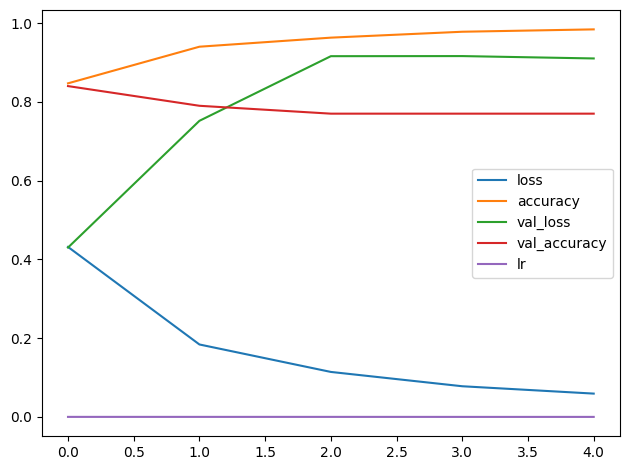

In [ ]:
# Plot the learning curves
history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots()
history_df.plot(ax=ax)
plt.tight_layout()
plt.savefig(experiment_path+'/learning_curve_after_unfreezing.png')
plt.show()

In [ ]:
# Reload the best weights from either first phase or second phase
try:
    model.load_weights(filepath=experiment_path+'/model.h5')
except ValueError:
    # If best model was before unfreezeing, layers must be frozen again
    for layer in pretrained_model.layers:
        layer.trainable = False
    model.load_weights(filepath=experiment_path+'/model.h5')

In [ ]:
# Check validation accuracy
loss, accuracy = model.evaluate(data_val)
accuracy

4/4 [==============================] - 4s 931ms/step - loss: 0.2640 - accuracy: 0.9000


0.8999999761581421

MobileNetV3-Small achieves 90% accuracy on validation set.

---
**NASNetMobile**

NASNetMobile is a CNN for mobile applications. It is a light-weight version of the NASNet model, whose architecture was obtained using the novel search algorithm described in https://arxiv.org/abs/1707.07012.

In [ ]:
# Set path for experiment outputs
experiment_path = os.path.dirname(ROOT+'/result_3/')

In [ ]:
# Create directory for model if not exists
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [ ]:
# Write a note with the model name
with open(experiment_path+'/note.txt', 'w', encoding='utf-8') as outfile:
    print('NASNetMobile', file=outfile)

In [ ]:
# Set random state for weight initialization
tf.random.set_seed(SEED)

# Call the NASNetMobile model loader
model, pretrained_model = nasnet_mobile()

# Freeze pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)


In [ ]:
# Save model checkpoints
model_checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=experiment_path+'/model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
# Reduce learning rate on loss plateau
lr_reduce = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
# Allow early stopping if no improvement
early_stopping = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

In [ ]:
# Run first phase of training (just top layers)
history = model.fit(
    data_train,
    epochs=10,
    validation_data=data_val,
    callbacks=[model_checkpoints, lr_reduce, early_stopping],
)

Epoch 1/10
32/32 [==============================] - 65s 2s/step - loss: 0.6377 - accuracy: 0.7600 - val_loss: 0.4124 - val_accuracy: 0.8600 - lr: 0.0100
Epoch 2/10
32/32 [==============================] - 48s 1s/step - loss: 0.3665 - accuracy: 0.8950 - val_loss: 0.3302 - val_accuracy: 0.8700 - lr: 0.0100
Epoch 3/10
32/32 [==============================] - 46s 1s/step - loss: 0.2995 - accuracy: 0.9130 - val_loss: 0.2985 - val_accuracy: 0.8700 - lr: 0.0100
Epoch 4/10
32/32 [==============================] - 47s 1s/step - loss: 0.2658 - accuracy: 0.9210 - val_loss: 0.2812 - val_accuracy: 0.8800 - lr: 0.0100
Epoch 5/10
32/32 [==============================] - 46s 1s/step - loss: 0.2446 - accuracy: 0.9220 - val_loss: 0.2701 - val_accuracy: 0.8800 - lr: 0.0100
Epoch 6/10
32/32 [==============================] - 46s 1s/step - loss: 0.2296 - accuracy: 0.9220 - val_loss: 0.2622 - val_accuracy: 0.8800 - lr: 0.0100
Epoch 7/10
32/32 [==============================] - 46s 1s/step - loss: 0.2182 - a

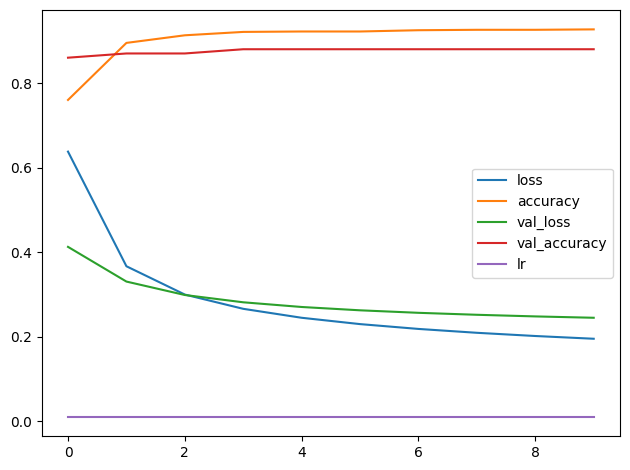

In [ ]:
# Plot the learning curves
history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots()
history_df.plot(ax=ax)
plt.tight_layout()
plt.savefig(experiment_path+'/learning_curve_before_unfreezing.png')
plt.show()

In [ ]:
# Reload best weights from first phase
model.load_weights(filepath=experiment_path+'/model.h5')

# Unfreeze pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = True

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)


In [ ]:
# Run second phase of training (full model)
history = model.fit(
    data_train,
    epochs=5,
    validation_data=data_val,
    callbacks=[model_checkpoints, lr_reduce, early_stopping],
)

Epoch 1/5
32/32 [==============================] - 173s 632ms/step - loss: 0.3602 - accuracy: 0.8640 - val_loss: 0.2737 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 2/5
32/32 [==============================] - 47s 1s/step - loss: 0.0329 - accuracy: 0.9950 - val_loss: 0.2152 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 3/5
32/32 [==============================] - 46s 1s/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.2029 - val_accuracy: 0.9100 - lr: 1.0000e-04
Epoch 4/5
32/32 [==============================] - 45s 1s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2038 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 5/5
32/32 [==============================] - 46s 1s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2059 - val_accuracy: 0.9200 - lr: 1.0000e-04


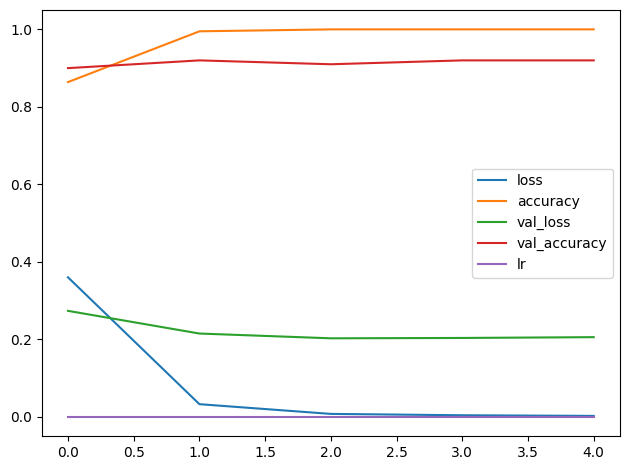

In [ ]:
# Plot the learning curves
history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots()
history_df.plot(ax=ax)
plt.tight_layout()
plt.savefig(experiment_path+'/learning_curve_after_unfreezing.png')
plt.show()

In [ ]:
# Reload the best weights from either first phase or second phase
try:
    model.load_weights(filepath=experiment_path+'/model.h5')
except ValueError:
    # If best model was before unfreezeing, layers must be frozen again
    for layer in pretrained_model.layers:
        layer.trainable = False
    model.load_weights(filepath=experiment_path+'/model.h5')

In [ ]:
# Check validation accuracy
loss, accuracy = model.evaluate(data_val)
accuracy

4/4 [==============================] - 4s 938ms/step - loss: 0.2152 - accuracy: 0.9200


0.9200000166893005

NASNetMobile achieves 92% accuracy on validation set.

---
### Holdout Testing

Now we apply our most accurate model (MobileNetV2) to the testing set to evaluate it.

In [ ]:
# Check accuracy of best model on testing data
model_dir = ROOT + '/result_1/'
model, pretrained_model = mobilenet_v2()

# Print the name of the model
with open(model_dir+'note.txt', 'r', encoding='utf-8') as infile:
    print(infile.read())

# Compile and load the model weights
model.compile(metrics=['accuracy'])
model.build((None, 768, 768, 3))

try:
    model.load_weights(filepath=model_dir+'model.h5')
except ValueError:
    # If best model was before unfreezeing, layers must be frozen again
    for layer in pretrained_model.layers:
        layer.trainable = False
    model.load_weights(filepath=model_dir+'model.h5')

9406464/9406464 [==============================] - 1s 0us/step
MobileNetV2



In [ ]:
# Double check validation accuracy
loss, accuracy = model.evaluate(data_val)
accuracy

4/4 [==============================] - 4s 929ms/step - loss: 0.0000e+00 - accuracy: 0.9500


0.949999988079071

In [ ]:
# Check testing accuracy
loss, accuracy = model.evaluate(data_test)
accuracy

4/4 [==============================] - 5s 976ms/step - loss: 0.0000e+00 - accuracy: 0.8400


0.8399999737739563

MobileNetV2 achieves 84% accuracy on testing set.

In [ ]:
y_true = np.concatenate([y.numpy() for _, y in data_test])
y_pred = model.predict(data_test).argmax(1)

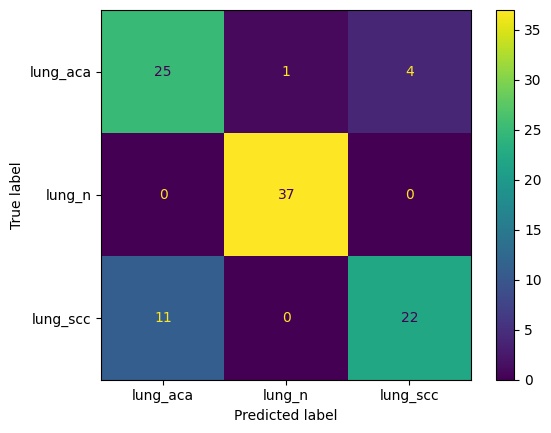

In [ ]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_true, y_pred),
    display_labels=[k for k, v in sorted(mapping.items(), key=lambda x: x[1])]
).plot()

---
---
---
# Conclusion

Through our experimentation we have found that the MobileNetV2 model had the highest validation accuracy, 95%. This is a 25% improvement from the baseline model (70%). To evaluate our modeling performance, we applied the fine-tuned MobileNetV2 to our testing set (which was held-out during the training phase). On the testing set, we achieved 84% accuracy. By examining the confusion matrix of the predictions, we note that the model is easily able to discriminate the benign class from the malignant classes, but struggles somewhat to separate the two malignant classes (adenocarcinoma and squamous cell carcinoma).

The 11% drop in performance from the validation set to the testing set is likely due to over-fitting. This problem can be addressed in future work by introducing L2 regularization, continuing to implement early-stopping, and possibly implementing label smoothing. Additionally, with better compute resources, we could increase the size of our training dataset and possibly implement further data augmentation. To address the difficulty in discriminating the two malignant classes, we could also experiment with giving less weight to the benign class in the loss function. This would cause the model to incur a greater penalty for mis-classifynig the two malignant classes.

## Citations

Borkowski, A. A. (2019, December 16). Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv.org. https://arxiv.org/abs/1912.12142v1

Wali, A., & LoCicero, R. (2022). Lung Cancer Grading: How Cancer Cells Look and Behave Compared With Normal Cells. MyLungCancerTeam. https://www.mylungcancerteam.com/resources/lung-cancer-grading-how-cancer-cells-look-and-behave-compared-with-normal-cells

Lung Cancer Survival Rates | 5-Year Survival Rates for Lung Cancer. (n.d.). https://www.cancer.org/cancer/types/lung-cancer/detection-diagnosis-staging/survival-rates.html

Sandler, Mark, et al. "Mobilenetv2: Inverted residuals and linear bottlenecks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018. https://arxiv.org/abs/1801.04381

Zoph, Barret, et al. "Learning transferable architectures for scalable image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018. https://arxiv.org/abs/1707.07012

Howard, Andrew, et al. "Searching for mobilenetv3." Proceedings of the IEEE/CVF international conference on computer vision. 2019. https://arxiv.org/abs/1905.02244